# Geometric multigrid solvers

In addition to the full gamut of algebraic solvers offered by PETSc, Firedrake also provides access to multilevel solvers with geometric hierarchies. In this tutorial, we will study strategies to solve the Stokes equations, demonstrating how the multigrid functionality composes with fieldsplit preconditioning.

*Note that currently, multigrid functionality is only implemented on simplex meshes in one and two dimensions.*

## Creating a geometric hierarchy

Geometric multigrid requires a geometric hierarchy of meshes on which the equations will be discretised.  For now, Firedrake supports hierarchies of *regularly refined* meshes, which we create by providing a *coarse mesh* and building a `MeshHierarchy`.  This hierarchy encapsulates the relationship between coarse and fine cells.

In [1]:
from __future__ import division
%matplotlib notebook
from firedrake import *

coarse_mesh = RectangleMesh(15, 10, 1.5, 1)

Having made the coarse mesh, we create the hierarchy of meshes.  The second argument tells Firedrake how many levels of refinement to use.  Here we refine three times, so that in total we have four meshes.

In [2]:
hierarchy = MeshHierarchy(coarse_mesh, 3)

The `hierarchy` object behaves like a Python *iterable*, so we can ask for its length and index it to extract meshes on a given level in the normal way:

In [3]:
len(hierarchy)

4

In [4]:
finest_mesh = hierarchy[-1]

### Grid transfer

If you want to control all aspects of the multigrid cycle, Firedrake offers the necessary building blocks.  You just need to create the relevant objects on the levels of the mesh hierarchy, and then use provided functions to transfer information between levels.

Firedrake provides the three functions, `prolong`, `restrict`, and `inject`.

- `prolong` transfers primal quantities from coarse to fine meshes.
- `restrict` transfers dual quantities (residuals) from fine to coarse meshes.  It is the dual of `prolong`.
- `inject` transfers primal quantities from fine to coarse meshes.

Most of the time, there is no need to access the interface at this level.  Instead, it suffices to define the variational problem on the finest level of a mesh hierarchy and then drive the solver using PETSc options.  This is the most flexible method, which we now demonstrate.

## Exercise

Look at the difference between the primal and dual fine to coarse transfer operations on a one-dimensional mesh for a function composed of piecewise linears.

## Problem setup

We will solve the Stokes equations on a rectangular domain $\Omega = [0, 1.5] \times [0, 1]$.  With constant inflow and outflow through two "pipes" and no slip boundaries everywhere else.

Our problem is to find $(u, p) \in V\times Q$ such that:

$$
\begin{align}
-\nu \nabla^2 u + \nabla p &= 0 \quad \text{in $\Omega$}\\
\nabla \cdot u &= 0 \quad \text{in $\Omega$}\\
u &= u_0 \quad \text{on $\Gamma_{\text{inout}}$}\\
u &= (0, 0) \quad \text{on $\Gamma \setminus \Gamma_{\text{inout}}$}
\end{align}
$$
where 
$$
\Gamma_\text{inout}(x, y) = \{(x, y)\, |\, y \in [1/6, 1/3] \cup [2/3, 5/6], x \in \{0, 1.5\} \}
$$
and
$$
u_0(x, y) = \bigg\{\
\begin{split} 
1 - (12 (y - 1/4))^2 \quad y &< 1/2 \\
1 - (12 (y - 3/4))^2 \quad y &> 1/2 \\
\end{split}
$$

We will use Taylor-Hood elements.  In the usual way, we multiply by test functions and after integrating by parts and incorporating boundary conditions, we arrive at the weak formulation, find $(u, p) \in V \times Q$ such that

$$
\begin{align}
\int_\Omega \nu \nabla u : \nabla v - p\nabla \cdot v\,\text{d}x &= 0 \quad \forall v \in V\\
\int_\Omega q \nabla \cdot u\,\text{d}x &= 0 \quad \forall q \in Q \\
u &= (1, 0) \quad \text{on $\Gamma_{\text{inout}}$}\\
u &= (0, 0) \quad \text{on $\Gamma \setminus \Gamma_{\text{inout}}$}.
\end{align}
$$

## Implementation

To make things easier to play with, we'll wrap everything up in a function that we can call to produce a solver.

In [35]:
def create_solver(parameters=None, use_ap=False):
    coarse_mesh = RectangleMesh(15, 10, 1.5, 1)
    hierarchy = MeshHierarchy(coarse_mesh, 3)
    
    mesh = hierarchy[-1]
    
    V = VectorFunctionSpace(mesh, "CG", 2)
    Q = FunctionSpace(mesh, "CG", 1)
    W = V*Q
    
    u, p = TrialFunctions(W)
    v, q = TestFunctions(W)
    
    nu = Constant(1)
    x, y = SpatialCoordinate(mesh)
    
    t = conditional(y < 0.5, y - 1/4, y - 3/4)
    gbar = conditional(Or(And(1/6 < y,
                              y < 1/3),
                          And(2/3 < y,
                              y < 5/6)),
                       1, 
                       0)

    value = as_vector([gbar*(1 - (12*t)**2), 0])
    bcs = [DirichletBC(W.sub(0), interpolate(value, V), (1, 2)),
           DirichletBC(W.sub(0), zero(2), (3, 4))]
    
    a = (nu*inner(grad(u), grad(v)) - p*div(v) + q*div(u))*dx
    L = inner(Constant((0, 0)), v)*dx
    
    # Preconditioning matrix
    if use_ap:
        aP = a + 1/nu * p*q*dx
    else:
        aP = None
    
    wh = Function(W)
    problem = LinearVariationalProblem(a, L, wh, bcs=bcs, aP=aP)
    solver = LinearVariationalSolver(problem, solver_parameters=parameters)
    return solver

In [36]:
solver = create_solver({"ksp_type": "preonly",
                        "pc_type": "lu",
                        "pc_factor_shift_type": "inblocks",
                        "ksp_monitor": True,
                        "pmat_type": "aij"})
solver.solve()

We can extract the solution variable from the solver object and plot the velocity field.  Plotting the pressure field uses an inordinately large amount of memory, so we do not do so here.

<IPython.core.display.Javascript object>


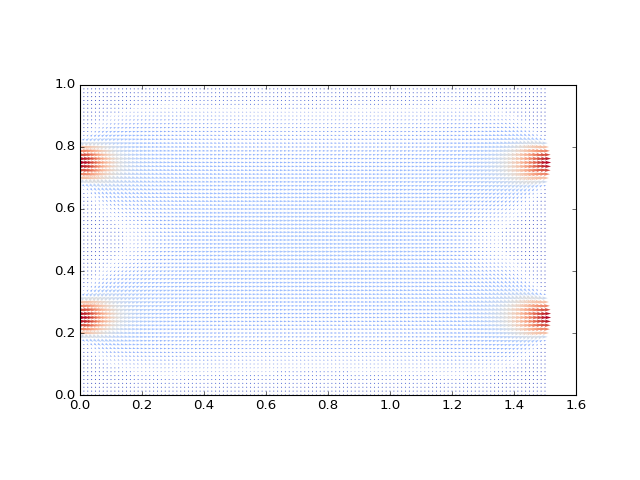

In [28]:
w = solver._problem.u
u, p = w.split()
axes = plot(u)
axes.set_aspect("equal");

This direct method is not a scalable solution technique for large problems.  Similar to our earlier example involving the mixed Poisson problem, a Schur complement method can be more efficient.  We'll use geometric multigrid to invert the elliptic velocity block, and use a viscosity-weighted pressure mass matrix to precondition the Schur complement.  This gives good results as long as viscosity contrasts are not too strong.

In [33]:
parameters = {
    "ksp_type": "gmres",
    "ksp_monitor": True,
    "pc_type": "fieldsplit",
    "pc_use_amat": True,
    "pc_fieldsplit_type": "schur",
    "pc_fieldsplit_schur_fact_type": "lower",
    "fieldsplit_0_ksp_type": "preonly",
    "fieldsplit_0_pc_type": "mg",
    "fieldsplit_1_ksp_type": "preonly",
    "fieldsplit_1_ksp_rtol": 1e-10, 
    "fieldsplit_1_pc_type": "bjacobi",
    "fieldsplit_1_sub_pc_type": "icc",
}

solver = create_solver(parameters, use_ap=True)
solver.solve()

Another option is to use a distributive smoother.  Instead of using a Schur complement on the outside and multigrid for the velocity block, we can instead use multigrid on the outside and Schur complements as a "smoother" on each level.  This requires more parameters, but no other change in our problem setup.

Note that we would like to be able to pass a preconditioning matrix (so that the Schur complement on the coarse levels can be preconditioned by a viscosity-weighted pressure mass matrix).  Unfortunately this is not currently functionality that PETSc supports.  So instead we just iterate a few times with unpreconditioned Richardson iterations.

In [43]:
parameters = {
      "ksp_type": "fgmres",
      "ksp_monitor": True,
      "mat_type": "nest",
      "pc_type": "mg",
      "mg_coarse_ksp_type": "preonly",
      "mg_coarse_pc_type": "fieldsplit",
      "mg_coarse_pc_fieldsplit_type": "schur",
      "mg_coarse_pc_fieldsplit_schur_fact_type": "full",
      "mg_coarse_fieldsplit_0_ksp_type": "preonly",
      "mg_coarse_fieldsplit_0_pc_type": "lu",
      "mg_coarse_fieldsplit_1_ksp_type": "richardson",
      "mg_coarse_fieldsplit_1_ksp_richardson_self_scale": True,
      "mg_coarse_fieldsplit_1_ksp_max_it": 5,
      "mg_coarse_fieldsplit_1_pc_type": "none",
      "mg_levels_ksp_type": "richardson",
      "mg_levels_ksp_max_it": 1,
      "mg_levels_pc_type": "fieldsplit",
      "mg_levels_pc_fieldsplit_type": "schur",
      "mg_levels_pc_fieldsplit_schur_fact_type": "upper",
      "mg_levels_fieldsplit_0_ksp_type": "richardson",
      "mg_levels_fieldsplit_0_ksp_max_it": 2,
      "mg_levels_fieldsplit_0_ksp_richardson_self_scale": True,
      "mg_levels_fieldsplit_0_pc_type": "bjacobi",
      "mg_levels_fieldsplit_0_sub_pc_type": "ilu",
      "mg_levels_fieldsplit_1_ksp_type": "richardson",
      "mg_levels_fieldsplit_1_ksp_richardson_self_scale": True,
      "mg_levels_fieldsplit_1_ksp_max_it": 3,
      "mg_levels_fieldsplit_1_pc_type": "none",
}

solver = create_solver(parameters)
solver.solve()

# Exercise

Play around with the problem setup to see how the solver performance changes when you introduce variable viscosity.  Do you have mesh-independent iteration counts in the presence of variable viscosity (add more levels to the mesh hierarchy).  How do things compare with algebraic multigrid (use `pc_type`: `hypre` or `pc_type`: `gamg`).

- Hint 1: use `conditional` to produce an expression that varies the viscosity spatially
- Hint 2: the first Schur complement method is probably your best bet (since the second doesn't include the viscosity in the preconditioning operator).
- Hint 3: You can determine the iteration count after the solver has finished using `solver.snes.ksp.getIterationNumber()`.